In [1]:
# install dependencies
%pip install -q \
  matplotlib \
  pandas \
  pycaret \
  "pycaret[analysis]" \
  seaborn

DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [2]:
# set up the environment for the notebook
import os
os.environ['PYCARET_CUSTOM_LOGGING_LEVEL'] = 'CRITICAL'

import pandas
pandas.set_option('display.max_columns', 128)

In [3]:
# prepare the data
from pathlib import Path
from pycaret.datasets import get_data
from zipfile import ZipFile

data_name = 'heart_2022_no_nans'

# extract the compressed data file
if Path(f'../data/{data_name}.csv').exists():
  print(f'Data file "{data_name}" was already extracted')
else:
  ZipFile(f'../data/{data_name}.zip', 'r').extract(
    f'data/{data_name}.csv', '..'
  )
  print(f'Data file "{data_name}" has been extracted successfully')

# load the data
print(f'Loading data file "{data_name}"')
DATA = get_data(dataset=f'../data/{data_name}')

Data file "heart_2022_no_nans" was already extracted
Loading data file "heart_2022_no_nans"


,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,HadAngina,HadStroke,HadAsthma,HadSkinCancer,HadCOPD,HadDepressiveDisorder,HadKidneyDisease,HadArthritis,HadDiabetes,DeafOrHardOfHearing,BlindOrVisionDifficulty,DifficultyConcentrating,DifficultyWalking,DifficultyDressingBathing,DifficultyErrands,SmokerStatus,ECigaretteUsage,ChestScan,RaceEthnicityCategory,AgeCategory,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,4.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,Former smoker,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 65 to 69,1.60,71.67,27.99,No,No,Yes,Yes,"Yes, received Tdap",No,No
1,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,6.0,None of them,No,No,No,No,No,No,No,No,Yes,Yes,No,No,No,No,No,No,Former smoker,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 70 to 74,1.78,95.25,30.13,No,No,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,No
2,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,"6 or more, but not all",No,No,No,No,No,No,No,No,Yes,No,No,Yes,No,Yes,No,No,Former smoker,Never used e-cigarettes in my entire life,Yes,"White only, Non-Hispanic",Age 75 to 79,1.85,108.86,31.66,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
3,Alabama,Female,Fair,5.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,No,No,No,Yes,No,Yes,No,Yes,No,No,No,No,Yes,No,No,Never smoked,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 80 or older,1.70,90.72,31.32,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
4,Alabama,Female,Good,3.0,15.0,Within past year (anytime less than 12 months ...,Yes,5.0,1 to 5,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 80 or older,1.55,79.38,33.07,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No


In [4]:
# setting column specifications
TARGET_NAME = 'HadHeartAttack'
IDENTIFIERS = ['State']

In [5]:
# establish an experiment
from pycaret.classification import ClassificationExperiment

exp = ClassificationExperiment()
exp.setup(
  data=DATA,
  train_size=0.7,
  target=TARGET_NAME,
  ignore_features=IDENTIFIERS,
  index=True,
  session_id=123,
  remove_multicollinearity=True,
  multicollinearity_threshold=0.9,
  imputation_type=None,
  fold_shuffle=True,
  max_encoding_ohe=25,
  remove_outliers=True,
  outliers_threshold=0.05,
  # fix_imbalance=True,
  # fix_imbalance_method='ADASYN',
  # group_features={
  #   'Group_Sickness': [
  #     'HadHeartAttack',
  #     'HadAngina',
  #     'HadStroke',    
  #     'HadAsthma',
  #     'HadSkinCancer',
  #     'HadCOPD',
  #     'HadDepressiveDisorder',
  #     'HadKidneyDisease',
  #     'HadArthritis',  
  #     'HadDiabetes',
  #     'RemovedTeeth',
  #   ],
  #   'Group_Difficulty': [
  #     'DeafOrHardOfHearing',
  #     'BlindOrVisionDifficulty',   
  #     'DifficultyConcentrating',
  #     'DifficultyWalking',
  #     'DifficultyDressingBathing',
  #     'DifficultyErrands',
  #   ],
  #   'Group_Behavior': [
  #     'SmokerStatus',
  #     'ECigaretteUsage',
  #     'AlcoholDrinkers',
  #   ],
  #   'Group_Vax': [
  #     'FluVaxLast12',
  #     'PneumoVaxEver',
  #     'TetanusLast10Tdap',
  #     'CovidPos',
  #   ],
  #   'Group_Health': [
  #     'GeneralHealth',
  #     'PhysicalHealthDays',
  #     'MentalHealthDays',
  #     'LastCheckupTime',
  #     'PhysicalActivities',
  #   ],
  # },
)
exp.dataset_transformed

,Description,Value
0,Session id,123
1,Target,HadHeartAttack
2,Target type,Binary
3,Target mapping,"No: 0, Yes: 1"
4,Original data shape,"(246022, 40)"
5,Transformed data shape,"(237411, 79)"
6,Transformed train set shape,"(163604, 79)"
7,Transformed test set shape,"(73807, 79)"
8,Ignore features,1
9,Ordinal features,22


,Sex,GeneralHealth_Very good,GeneralHealth_Excellent,GeneralHealth_Good,GeneralHealth_Fair,GeneralHealth_Poor,PhysicalHealthDays,MentalHealthDays,LastCheckupTime_5 or more years ago,LastCheckupTime_Within past year (anytime less than 12 months ago),LastCheckupTime_Within past 5 years (2 years but less than 5 years ago),LastCheckupTime_Within past 2 years (1 year but less than 2 years ago),PhysicalActivities,SleepHours,RemovedTeeth_1 to 5,RemovedTeeth_None of them,"RemovedTeeth_6 or more, but not all",RemovedTeeth_All,HadAngina,HadStroke,HadAsthma,HadSkinCancer,HadCOPD,HadDepressiveDisorder,HadKidneyDisease,HadArthritis,HadDiabetes_No,HadDiabetes_Yes,"HadDiabetes_No, pre-diabetes or borderline diabetes","HadDiabetes_Yes, but only during pregnancy (female)",DeafOrHardOfHearing,BlindOrVisionDifficulty,DifficultyConcentrating,DifficultyWalking,DifficultyDressingBathing,DifficultyErrands,SmokerStatus_Never smoked,SmokerStatus_Former smoker,SmokerStatus_Current smoker - now smokes some days,SmokerStatus_Current smoker - now smokes every day,ECigaretteUsage_Never used e-cigarettes in my entire life,ECigaretteUsage_Use them every day,ECigaretteUsage_Not at all (right now),ECigaretteUsage_Use them some days,ChestScan,"RaceEthnicityCategory_White only, Non-Hispanic",RaceEthnicityCategory_Hispanic,"RaceEthnicityCategory_Black only, Non-Hispanic","RaceEthnicityCategory_Other race only, Non-Hispanic","RaceEthnicityCategory_Multiracial, Non-Hispanic",AgeCategory_Age 35 to 39,AgeCategory_Age 65 to 69,AgeCategory_Age 50 to 54,AgeCategory_Age 75 to 79,AgeCategory_Age 60 to 64,AgeCategory_Age 40 to 44,AgeCategory_Age 70 to 74,AgeCategory_Age 55 to 59,AgeCategory_Age 30 to 34,AgeCategory_Age 45 to 49,AgeCategory_Age 80 or older,AgeCategory_Age 25 to 29,AgeCategory_Age 18 to 24,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,"TetanusLast10Tdap_No, did not receive any tetanus shot in the past 10 years","TetanusLast10Tdap_Yes, received tetanus shot but not sure what type","TetanusLast10Tdap_Yes, received Tdap","TetanusLast10Tdap_Yes, received tetanus shot, but not Tdap",HighRiskLastYear,CovidPos_No,CovidPos_Yes,CovidPos_Tested positive using home test without a health professional,HadHeartAttack
183988,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.65,77.110001,28.290001,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
244323,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.57,50.349998,20.299999,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
9456,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.80,76.199997,23.430000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
57640,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.63,74.839996,28.320000,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
30227,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.65,58.060001,21.299999,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [6]:
# set global plot parameters
import matplotlib.pyplot as plt
import seaborn as sns

# reset old global plot parameters
plt.rcdefaults()

# adjustable global plot parameters
COLORMAP = sns.color_palette()
DPI = 400
OUTLINE_WIDTH = 0.2
plt.rcParams['axes.grid'] = False
plt.rcParams['axes.linewidth'] = OUTLINE_WIDTH
plt.rcParams['figure.dpi'] = DPI
plt.rcParams['font.size'] = 4
plt.rcParams['xtick.major.width'] = OUTLINE_WIDTH
plt.rcParams['xtick.minor.width'] = OUTLINE_WIDTH
plt.rcParams['ytick.major.width'] = OUTLINE_WIDTH
plt.rcParams['ytick.minor.width'] = OUTLINE_WIDTH

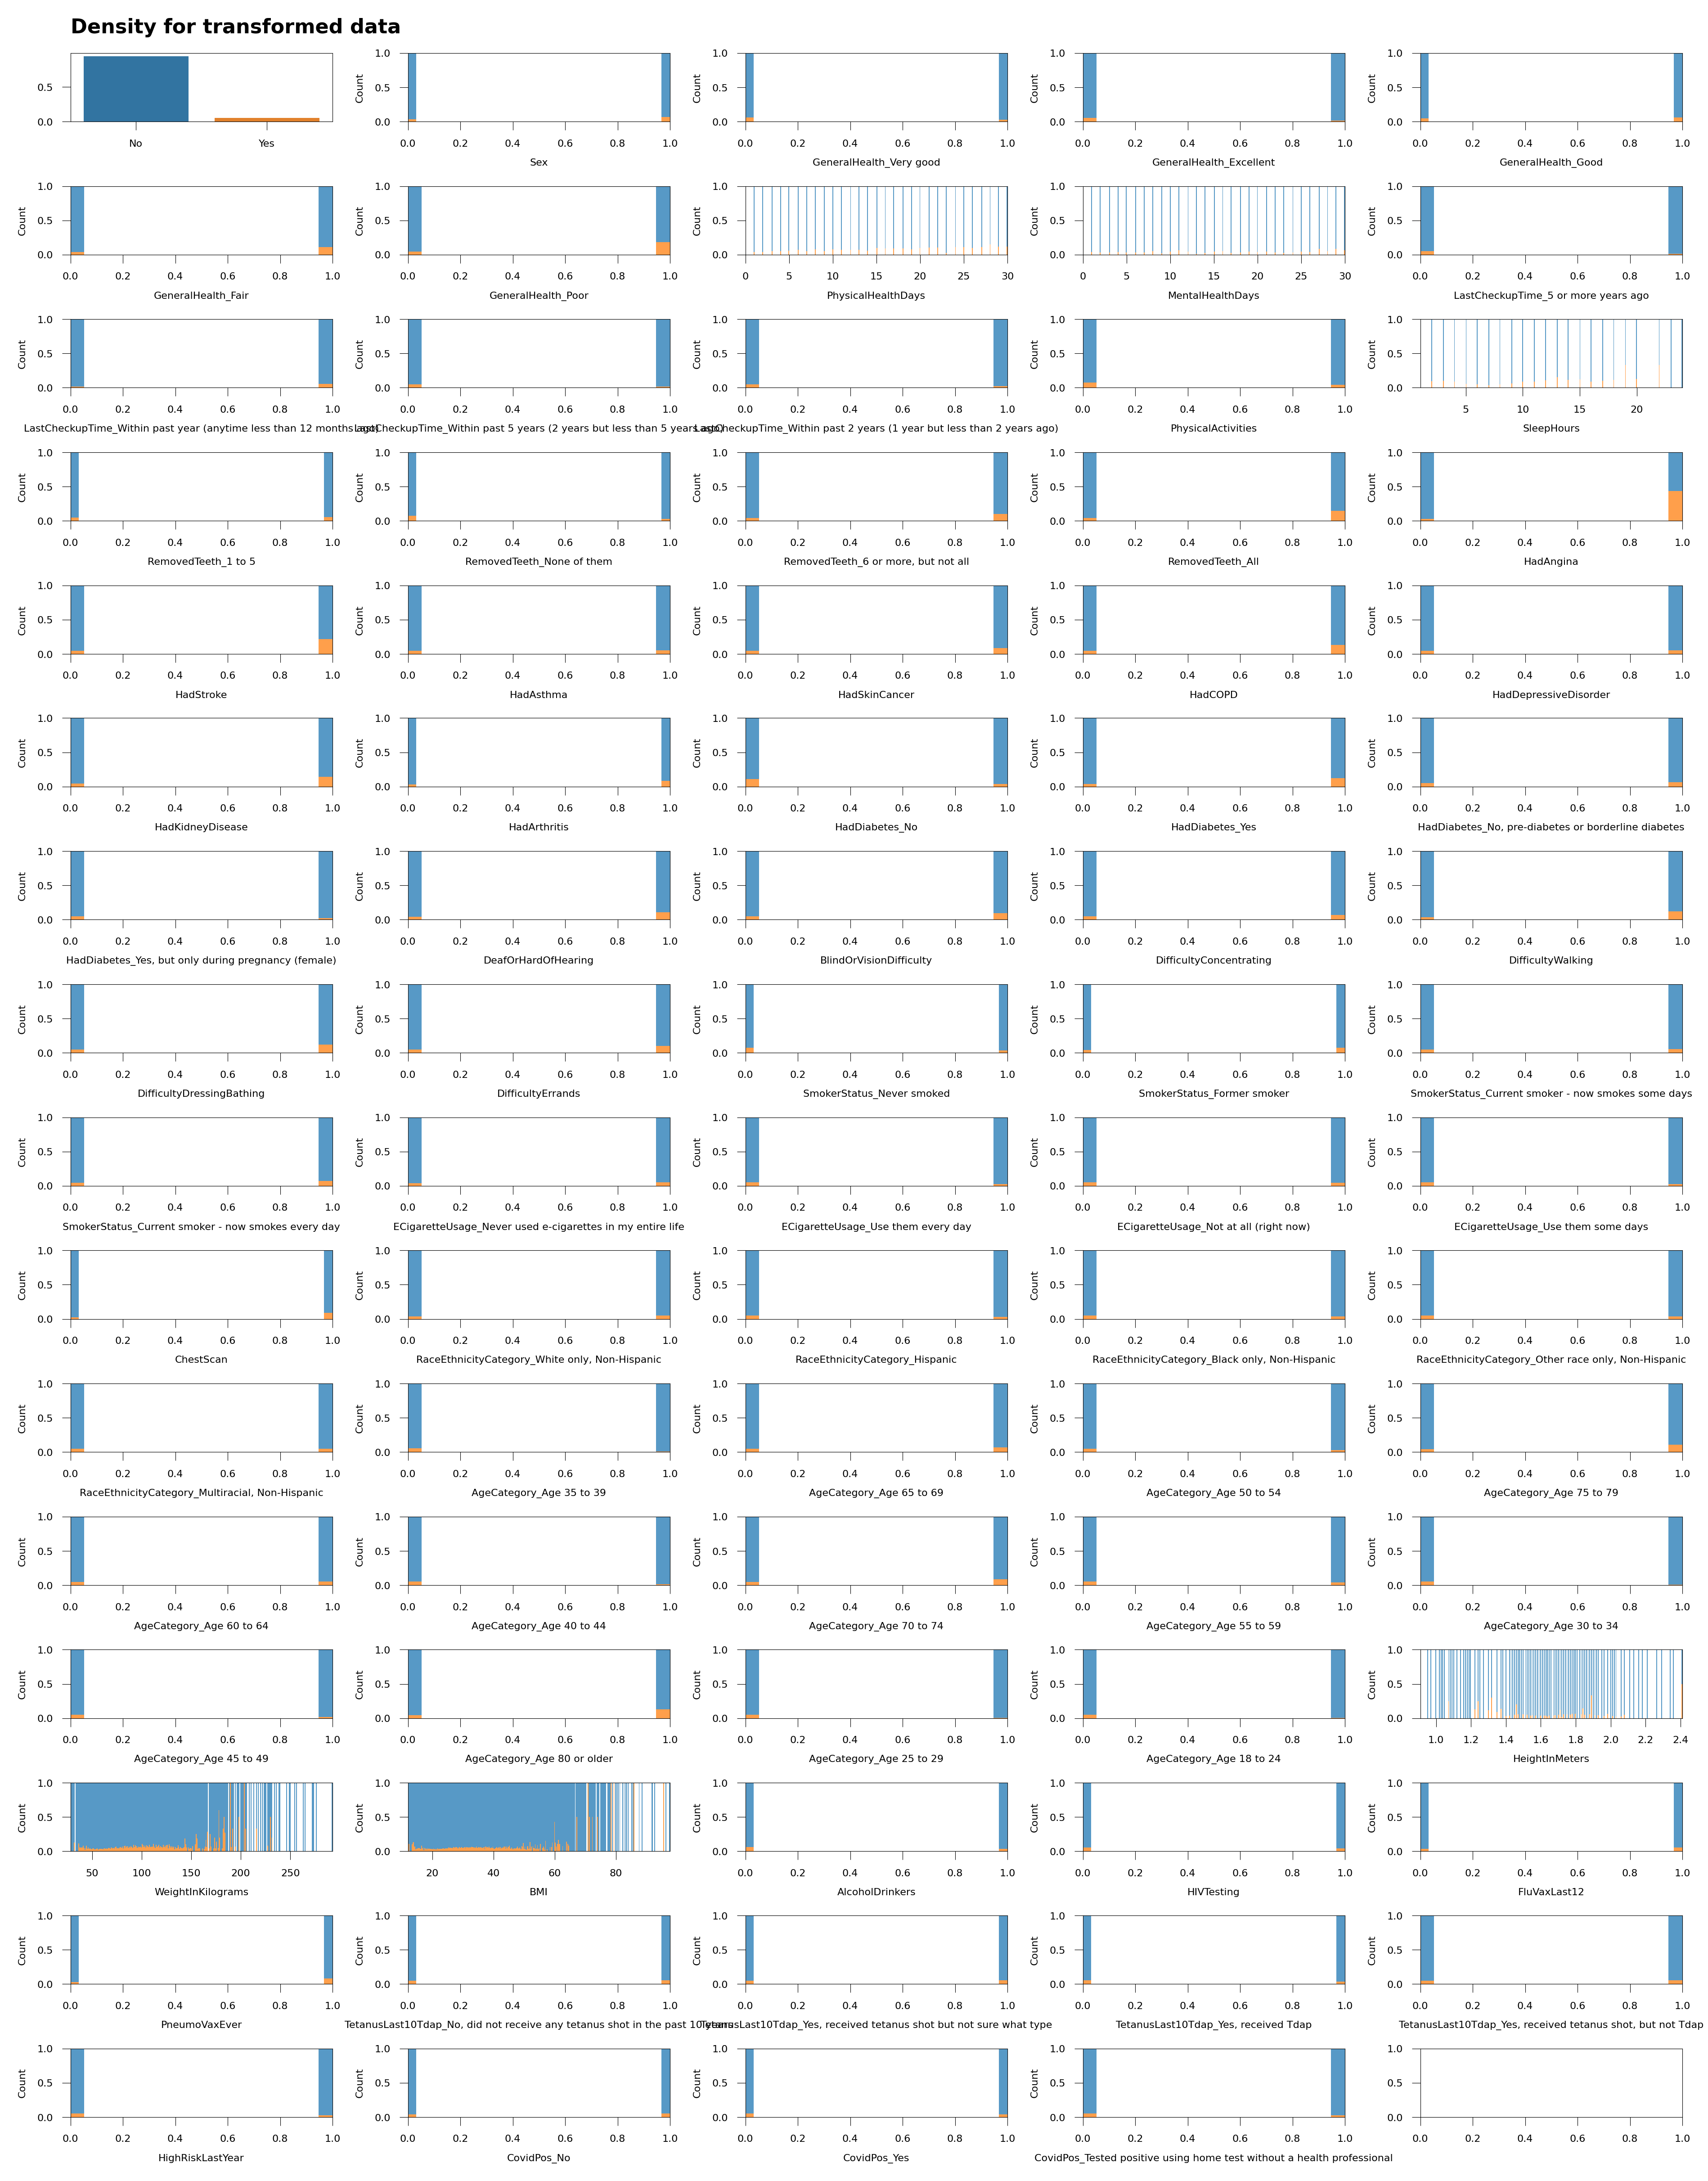

In [7]:
# show the distributions of the data
from math import ceil

# adjustable local plot parameters
TITLE = 'Density for transformed data'
SUBPLOT_SIZE = (750, 300)

# setting local plot parameters
plots_per_col = 5
shape = (plots_per_col, ceil(exp.dataset_transformed.shape[1] / plots_per_col))
figsize = tuple(pxs[0] * pxs[1] / DPI for pxs in zip(SUBPLOT_SIZE, shape))
title_params = {
  'fontdict': {
    'fontsize': plt.rcParams['font.size'] * 2,
    'fontweight': 'bold',
  },
  'loc': 'left',
  'pad': plt.rcParams['font.size'] * 2,
}
title_params['label'] = TITLE

# plot grid
axs = plt.subplots(
  nrows=shape[1],
  ncols=shape[0],
  layout='constrained',
  figsize=figsize,
)[1].flat

# plot target distribution
target_dist_data = exp.y.value_counts(normalize=True)
ax = sns.barplot(
  x=target_dist_data.index,
  y=target_dist_data.values,
  ax=axs[0],
  palette=COLORMAP,
)

# plot data title
axs[0].set_title(**title_params)

# plot features distribution
for x, ax in zip(exp.X_transformed.columns, axs[1:]):
  sns.histplot(
    data=exp.dataset_transformed,
    x=x,
    ax=ax,
    hue=TARGET_NAME,
    legend=False,
    linewidth=0,
    multiple='fill',
    palette=COLORMAP,
  )

# save the plot
plt.savefig(
  fname=f'../images/{TITLE}.png',
  bbox_inches='tight',
)

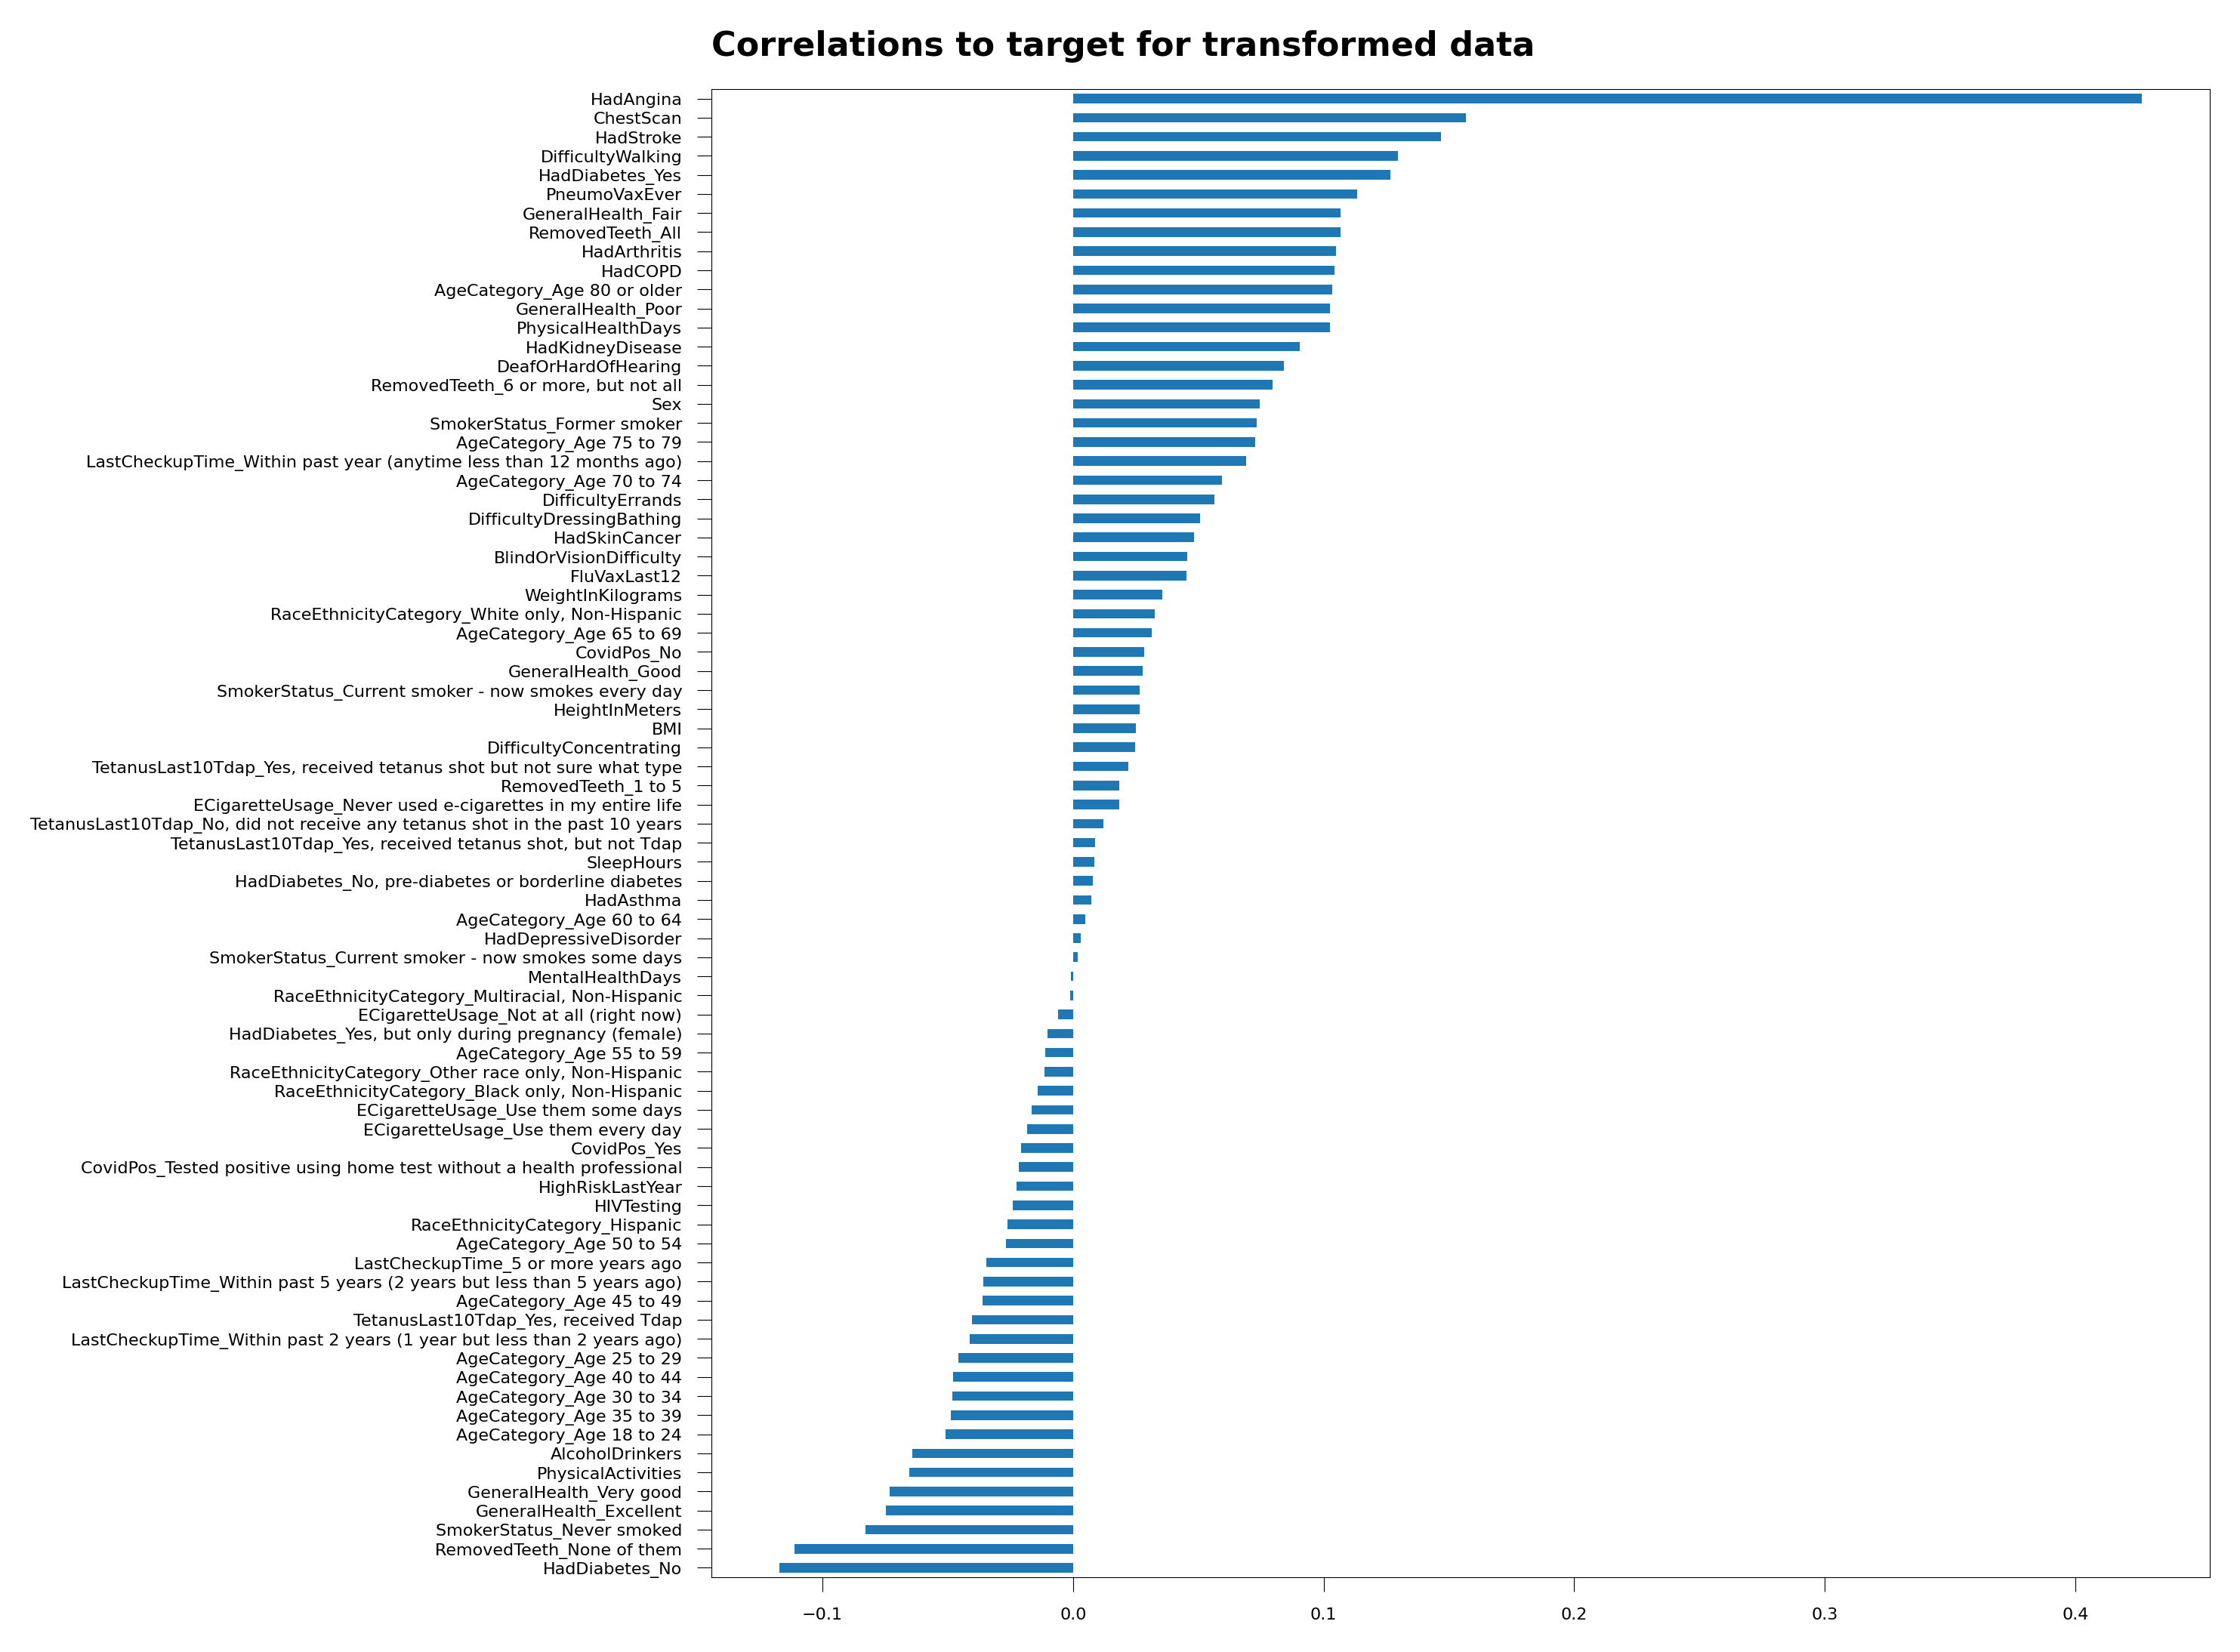

In [8]:
# check correlation between target and features
# adjustable plot parameters
TITLE = 'Correlations to target for transformed data'
PLOT_SIZE = (2560, 2560)

# setting plot parameters
figsize = tuple(px / DPI for px in PLOT_SIZE)
title_params['label'] = TITLE

# plot correlation to target
target_corr_data = (exp.dataset_transformed
  .corr()[TARGET_NAME]
  .drop(TARGET_NAME)
  .sort_values())
ax = target_corr_data.plot.barh(figsize=figsize)
ax.set_title(**title_params)

# save the plot
plt.savefig(
  fname=f'../images/{TITLE}.png',
  bbox_inches='tight',
)

In [9]:
# compare models with AUROC
candicate_model = exp.compare_models(
  exclude=[ # excludes slow and unsuitable models
    # 'catboost',
    # 'knn',
    # 'ridge',
    # 'svm',
  ],
  sort='auc',
  cross_validation=False,
)
None

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.9489,0.8854,0.9489,0.9368,0.9388,0.3181,0.3514,29.7600
lr,Logistic Regression,0.9483,0.8843,0.9483,0.9371,0.9399,0.3423,0.3657,28.9300
ada,Ada Boost Classifier,0.9475,0.8843,0.9475,0.9370,0.9402,0.3546,0.3719,13.6100
lda,Linear Discriminant Analysis,0.9388,0.8815,0.9388,0.9421,0.9404,0.4380,0.4388,9.9600
xgboost,Extreme Gradient Boosting,0.9463,0.8756,0.9463,0.9323,0.9355,0.2804,0.3107,9.5600
catboost,CatBoost Classifier,0.9473,0.8752,0.9473,0.9333,0.9358,0.2768,0.3130,18.4000
rf,Random Forest Classifier,0.9470,0.8686,0.9470,0.9309,0.9274,0.1338,0.2103,11.1100
et,Extra Trees Classifier,0.9464,0.8640,0.9464,0.9293,0.9304,0.1892,0.2442,11.6100
nb,Naive Bayes,0.6787,0.8366,0.6787,0.9399,0.7661,0.1417,0.2433,9.3400
qda,Quadratic Discriminant Analysis,0.5316,0.7744,0.5316,0.9338,0.6468,0.0726,0.1613,9.7200


In [10]:
# # if the ranking not shown, uncomment and run this cell
# exp.pull()

In [11]:
# assign the best model id manually

BEST_MODEL_ID = candicate_model

best_model = exp.create_model(
  estimator=BEST_MODEL_ID,
  cross_validation=False,
)
best_model

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Test,0.9489,0.8854,0.9489,0.9368,0.9388,0.3181,0.3514


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

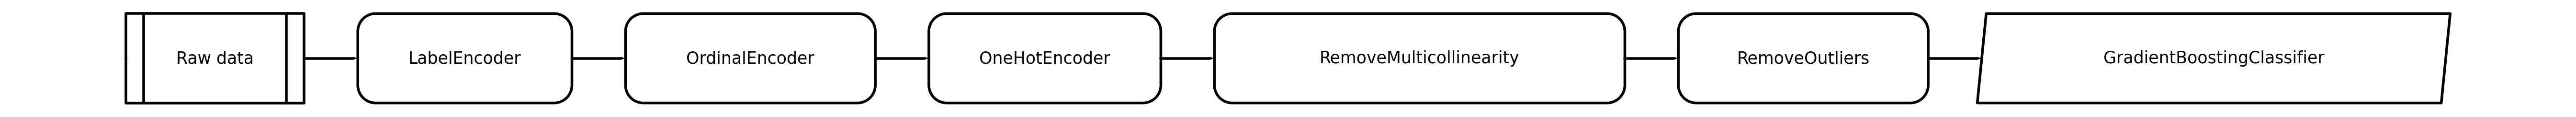

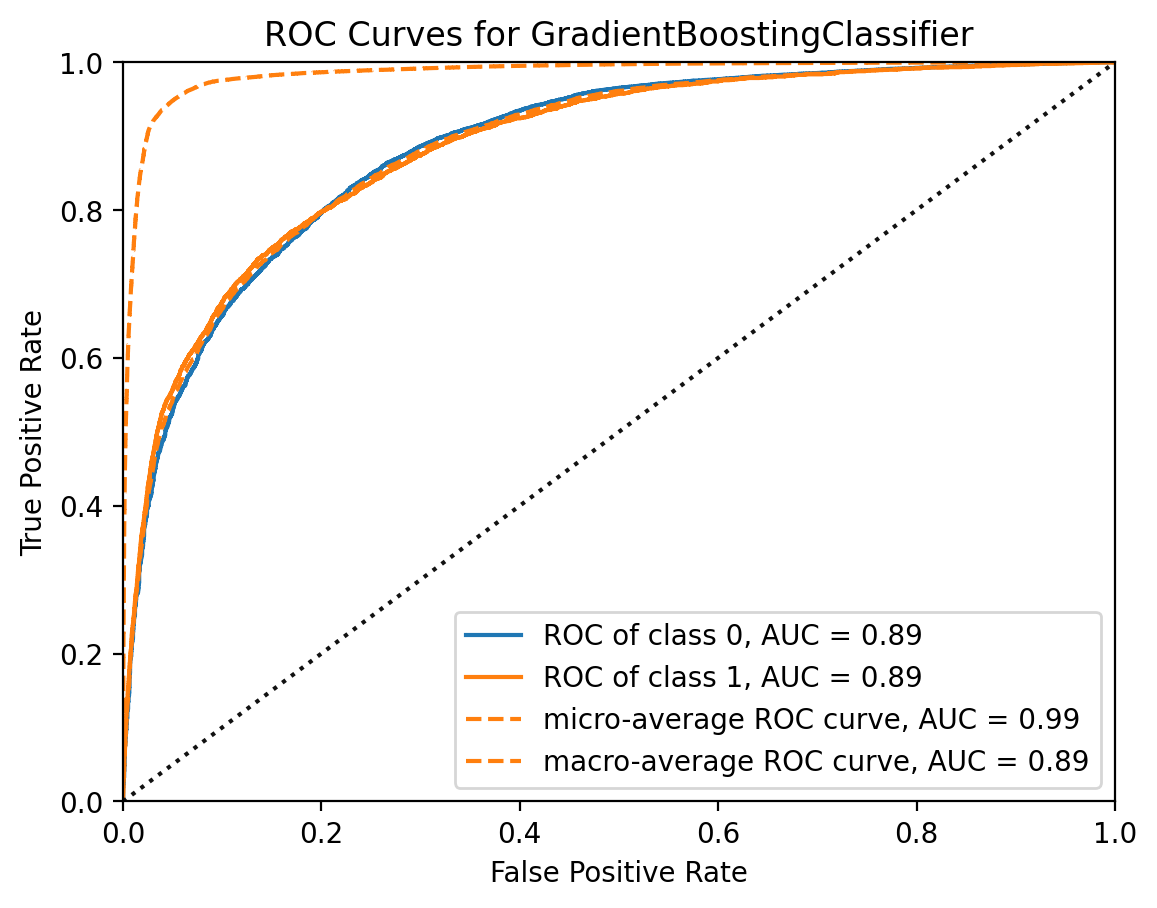

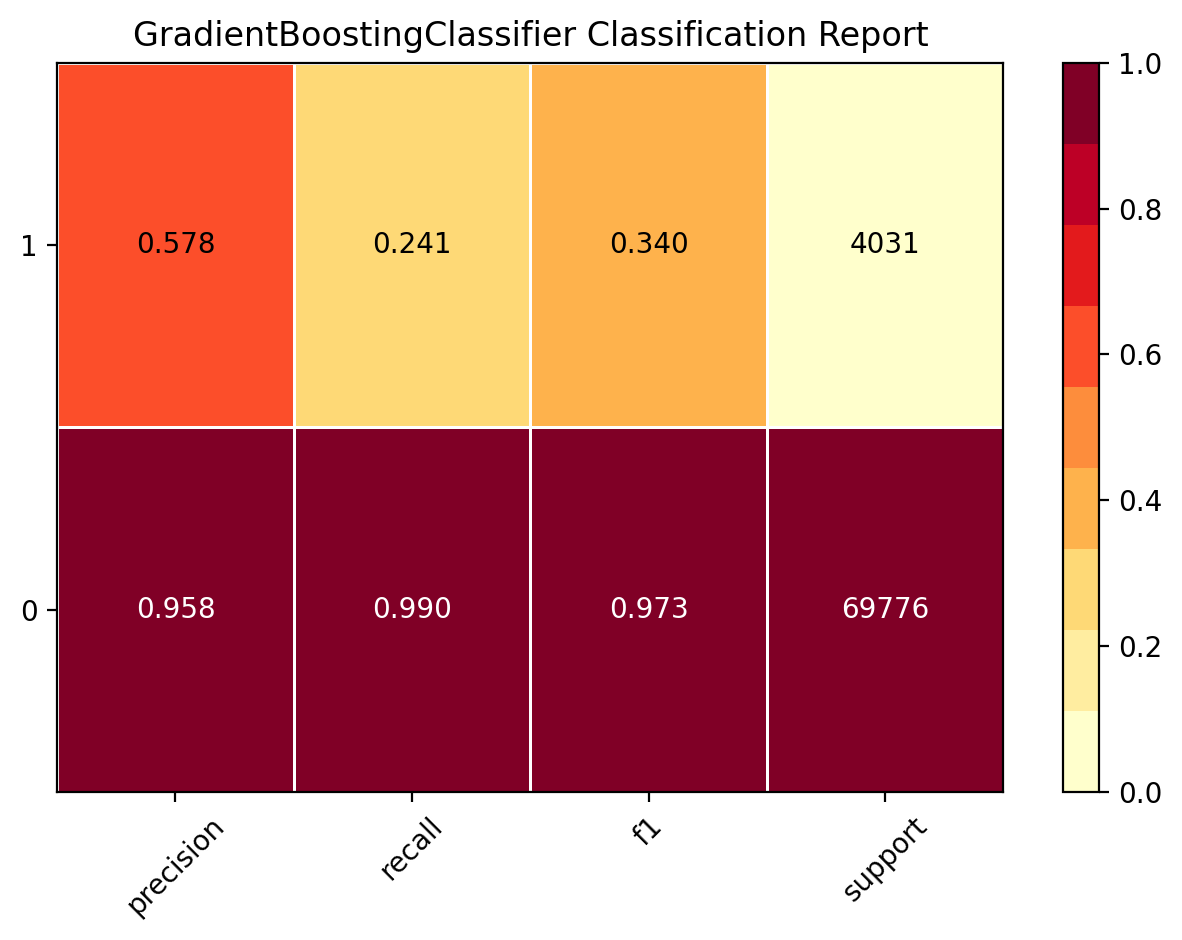

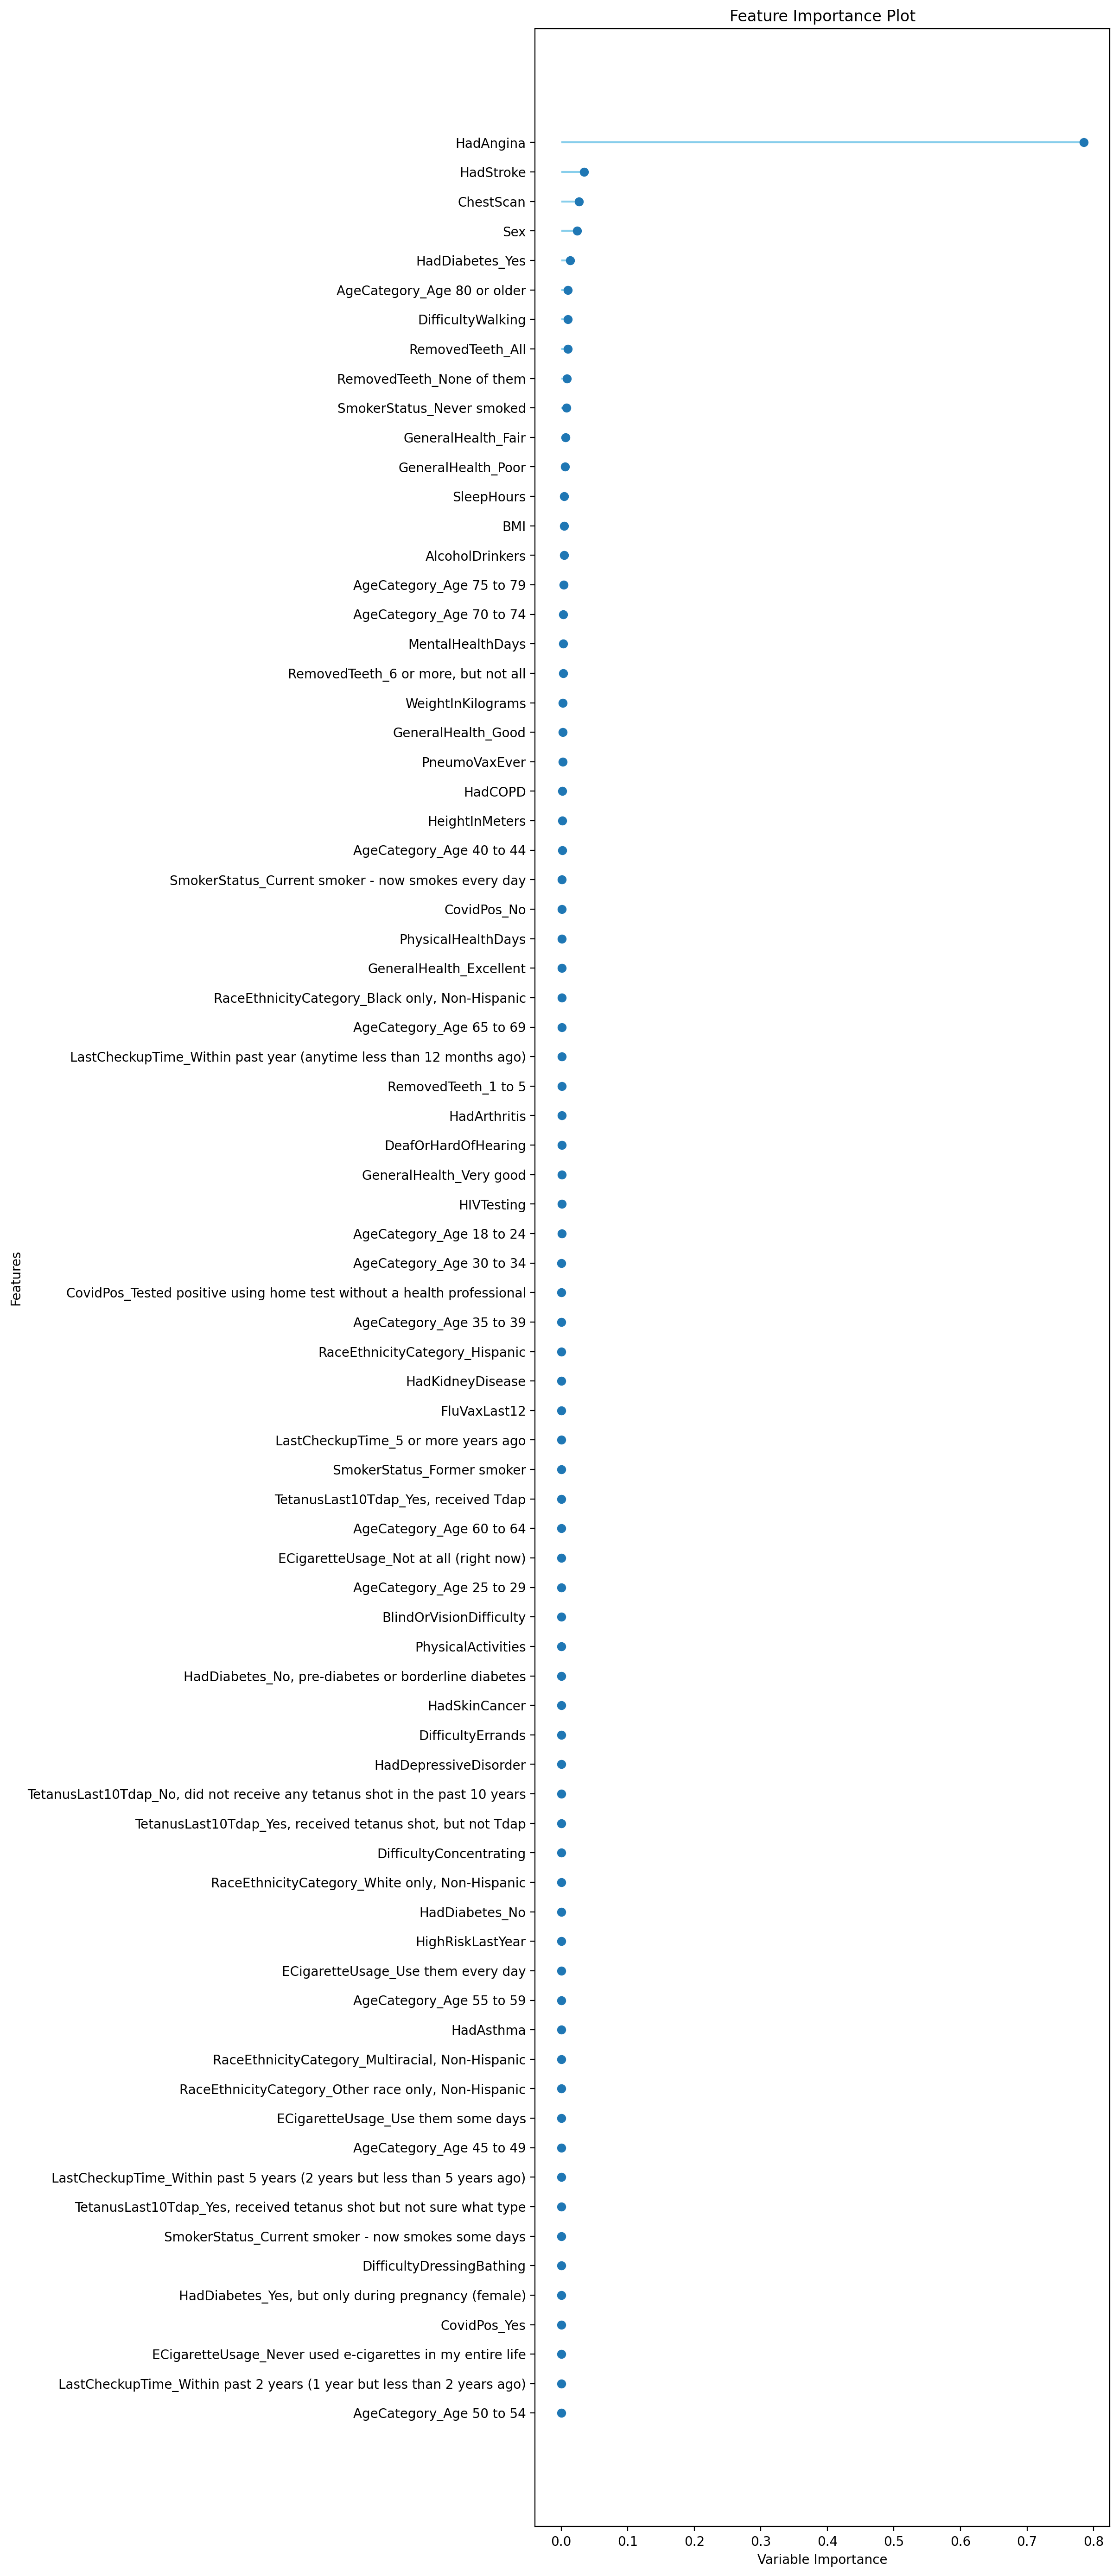

,Parameters
ccp_alpha,0.0
criterion,friedman_mse
init,None
learning_rate,0.1
loss,log_loss
max_depth,3
max_features,None
max_leaf_nodes,None
min_impurity_decrease,0.0
min_samples_leaf,1


In [12]:
# profile the best model
# reset old global plot parameters
plt.rcdefaults()

plot_types = [
  'pipeline',
  'auc',
  'class_report',
  'feature_all',
  'parameter',
]
for plot_type in plot_types:
  exp.plot_model(
    estimator=best_model,
    plot=plot_type,
    plot_kwargs={
      'block': False,
    },
    scale=2,
  )

In [13]:
# # # tune the best model

# tuned_best_model = exp.tune_model(
#   estimator=best_model,
#   optimize='auc',
#   n_iter=3,
# )
# exp.plot_model(
#   estimator=tuned_best_model,
#   plot='parameter',
#   plot_kwargs={
#     'block': False,
#   },
#   scale=2,
# )

In [14]:
# show hold-out predictions
predictions = exp.predict_model(
  estimator=best_model,
  raw_score=True,
)
predictions[filter(
  lambda name: name.startswith('prediction_'),
  predictions.columns,
)]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.9489,0.8854,0.9489,0.9368,0.9388,0.3181,0.3514


,prediction_label,prediction_score_No,prediction_score_Yes
190618,No,0.9251,0.0749
199737,No,0.9930,0.0070
56161,No,0.9402,0.0598
203854,No,0.9381,0.0619
141281,No,0.9838,0.0162
...,...,...,...
245885,No,0.9774,0.0226
189261,No,0.9930,0.0070
11001,No,0.9768,0.0232
176761,Yes,0.4111,0.5889


In [15]:
# save the experiment and model
from pathlib import Path

Path('../models/heart-best').mkdir(
  parents=True,
  exist_ok=True,
)

exp.save_experiment(
  path_or_file='../models/heart-best/experiment.pkl',
)
exp.save_model(
  model=best_model,
  model_name='../models/heart-best/model',
  model_only=False,
)
None

Transformation Pipeline and Model Successfully Saved
